___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Session - 10 Part -1<br><br>Univariate Time Series Forecasting with RNN<br><br>RSCCASN<br><h1>

# Data Info

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [7]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Recognizing and Understanding Data¶

In [9]:
df = pd.read_csv('/content/drive/MyDrive/RSCCASN.csv',
                index_col='DATE',
                parse_dates=True
                )

In [10]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [12]:
df.columns = ['Sales']

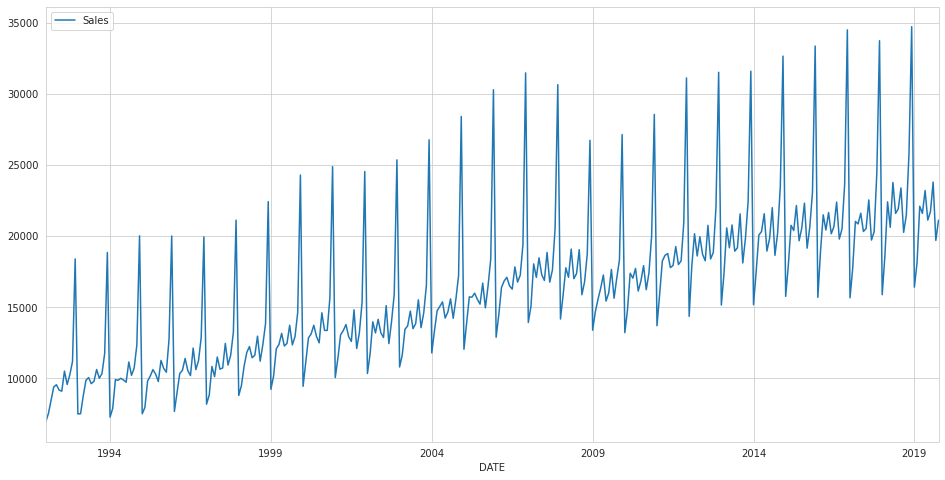

In [13]:
df.plot(figsize=(16,8))

# Preprocessing of Data

## Train Test Split

In [14]:
len(df)

334

In [15]:
test_size = 24

In [16]:
test_ind = len(df)- test_size
test_ind

310

In [17]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [18]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-06-01,20322
2017-07-01,20535
2017-08-01,22536


In [19]:
test

,Sales
DATE,
2017-11-01,24438
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


## Scaling

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler = MinMaxScaler()

In [22]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [23]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [24]:
# help(TimeseriesGenerator)

In [25]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [26]:
len(generator)

298

In [27]:
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]), array([[0.02047633]]))

In [28]:
X, y = generator[0]

In [29]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


# Modelling

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [31]:
train_scaled.shape

(310, 1)

In [32]:
n_features = train_scaled.shape[1]

In [33]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [35]:
# params = 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
4 * ((1+1)*100+(100**2))

40800

In [36]:
4 * ((100+1)*50+(50**2))

30200

## EarlyStopping and Validation Generator

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5,restore_best_weights = True)

In [39]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [40]:
len(validation_generator)

12

In [41]:
model.fit(x = generator,
          epochs = 120,
          validation_data = validation_generator,
          callbacks = [early_stop])

Epoch 1/120
298/298 [==============================] - 10s 8ms/step - loss: 0.0225 - val_loss: 0.0312
Epoch 2/120
298/298 [==============================] - 2s 6ms/step - loss: 0.0201 - val_loss: 0.0246
Epoch 3/120
298/298 [==============================] - 2s 6ms/step - loss: 0.0179 - val_loss: 0.0249
Epoch 4/120
298/298 [==============================] - 2s 6ms/step - loss: 0.0169 - val_loss: 0.0304
Epoch 5/120
298/298 [==============================] - 2s 6ms/step - loss: 0.0176 - val_loss: 0.0257
Epoch 6/120
298/298 [==============================] - 2s 6ms/step - loss: 0.0175 - val_loss: 0.0237
Epoch 7/120
298/298 [==============================] - 2s 6ms/step - loss: 0.0166 - val_loss: 0.0236
Epoch 8/120
298/298 [==============================] - 2s 6ms/step - loss: 0.0141 - val_loss: 0.0303
Epoch 9/120
298/298 [==============================] - 2s 6ms/step - loss: 0.0149 - val_loss: 0.0281
Epoch 10/120
298/298 [==============================] - 2s 6ms/step - loss: 0.0138 - val_l

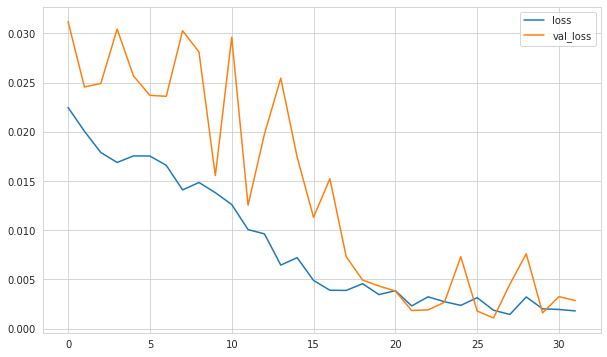

In [42]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

# Evaluation on Test Data

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [44]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [45]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [46]:
predictions_scaled

[array([0.6554659], dtype=float32),
 array([0.9498198], dtype=float32),
 array([0.34197247], dtype=float32),
 array([0.41757146], dtype=float32),
 array([0.5137713], dtype=float32),
 array([0.5118456], dtype=float32),
 array([0.521563], dtype=float32),
 array([0.4810011], dtype=float32),
 array([0.49054977], dtype=float32),
 array([0.5130158], dtype=float32),
 array([0.4416448], dtype=float32),
 array([0.4843023], dtype=float32)]

In [47]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.8951656364382812 
mae: 0.04092800948595376 
mse: 0.002321811250934913 
rmse: 0.04818517667223929


## Inverse Transformation and Comparing

In [48]:
predictions = scaler.inverse_transform(predictions_scaled)

In [49]:
compare = test[:12]

In [50]:
compare['Predictions'] = predictions

In [51]:
compare

,Sales,Predictions
DATE,,
2017-11-01,24438,24992.153
2017-12-01,33720,33099.837
2018-01-01,15881,16357.290
2018-02-01,18585,18439.588
2018-03-01,22404,21089.317
2018-04-01,20616,21036.275
2018-05-01,23764,21303.931
2018-06-01,21589,20186.695
2018-07-01,21919,20449.703


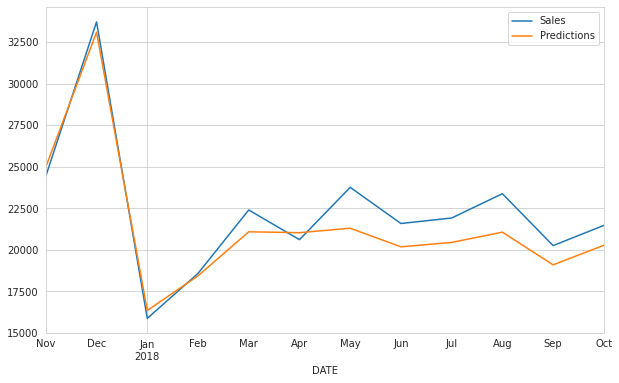

In [52]:
compare.plot()

In [53]:
eval_metrics(compare.Sales, compare.Predictions)

r2_score: 0.8951656364382808 
mae: 1127.3210932811119 
mse: 1761493.036773377 
rmse: 1327.2125062601608


# Retrain and Forecasting

In [54]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [55]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [56]:
len(df)

334

In [57]:
len(generator)

322

In [58]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit(x = generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 5s 6ms/step - loss: 0.0253
Epoch 2/15
322/322 [==============================] - 2s 5ms/step - loss: 0.0202
Epoch 3/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0185
Epoch 4/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0172
Epoch 5/15
322/322 [==============================] - 2s 5ms/step - loss: 0.0170
Epoch 6/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0163
Epoch 7/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0157
Epoch 8/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0152
Epoch 9/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0138
Epoch 10/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0122
Epoch 11/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0111
Epoch 12/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0084
Epoch 13/15
322/322 [====

In [59]:
scaled_full_data.shape

(334, 1)

In [60]:
scaled_full_data[-length:].shape

(12, 1)

In [61]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [62]:
forecast = scaler.inverse_transform(forecast)

In [63]:
forecast

array([[26692.9634366 ],
       [31593.13834906],
       [17365.86045909],
       [19220.37917566],
       [21631.19924736],
       [21481.41579723],
       [22034.68401861],
       [20782.60476685],
       [21322.07736015],
       [21582.62642193],
       [19853.80011106],
       [22274.61762142]])

In [64]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [65]:
forecast_index = pd.date_range(start = '2019-11-01', periods = length, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [66]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [67]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [68]:
forecast_df

,Forecast
2019-11-01,26692.963
2019-12-01,31593.138
2020-01-01,17365.860
2020-02-01,19220.379
2020-03-01,21631.199
2020-04-01,21481.416
2020-05-01,22034.684
2020-06-01,20782.605
2020-07-01,21322.077
2020-08-01,21582.626


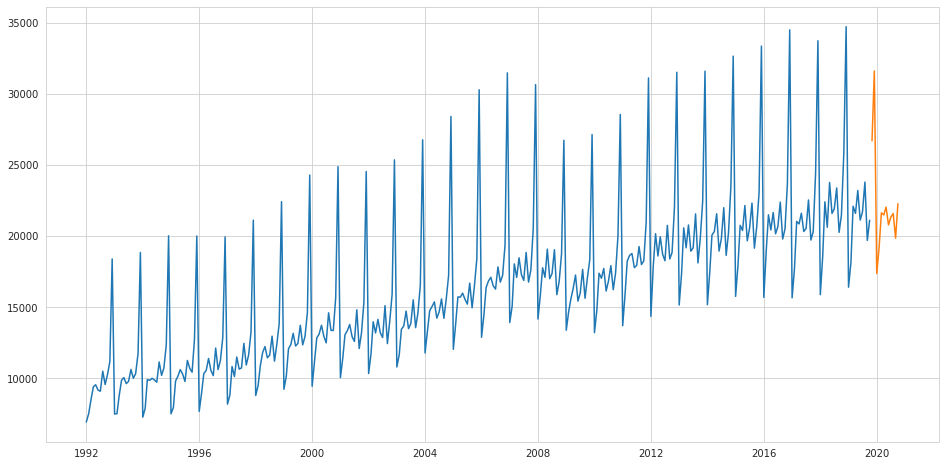

In [69]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

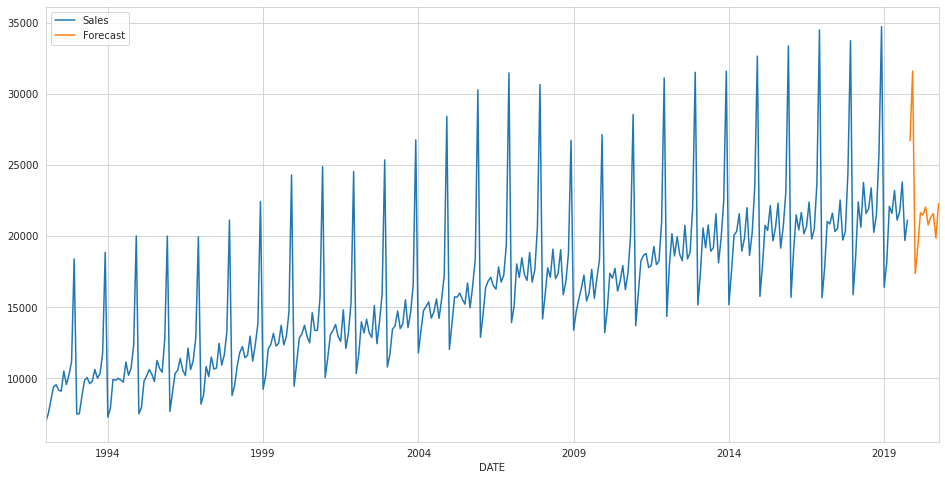

In [70]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

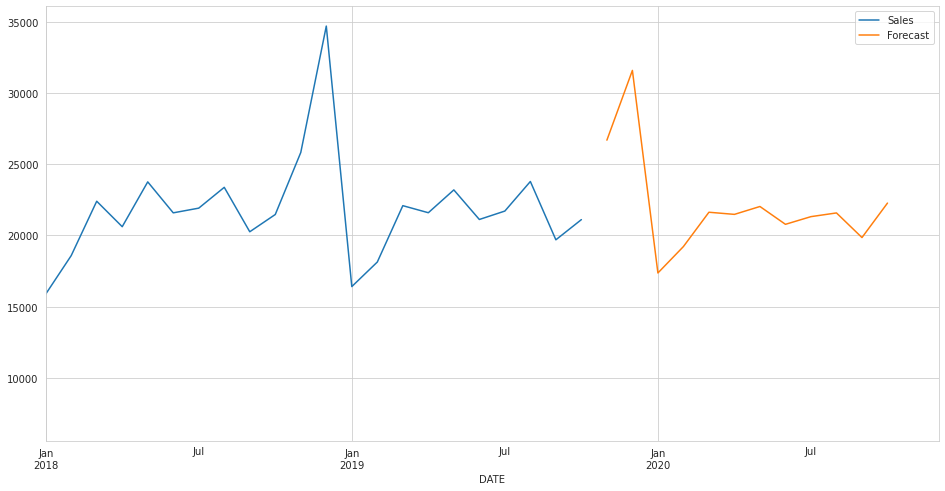

In [71]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')

In [72]:
dataset_total = pd.concat((df['Sales'], forecast_df['Forecast']), axis=0)

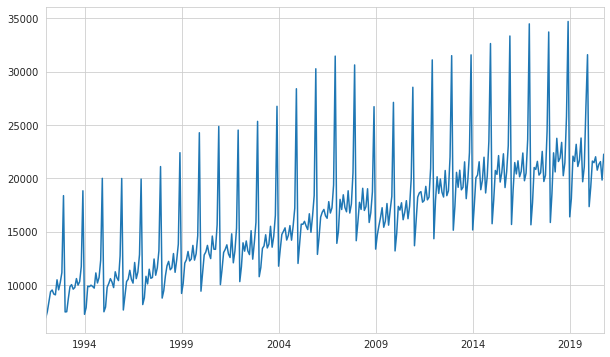

In [73]:
dataset_total.plot()

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___